In [1]:
from datetime import datetime
import warnings
import matplotlib.pyplot as plt
from meteo_api import MeteoAPI
from meteo_receiver import MeteoReceiver

Task 1 - MeteoAPI class

In [3]:
place_code = "kaunas"
station_code = "kauno-ams"
url = f"https://api.meteo.lt/v1/"
meteoAPI = MeteoAPI(place_code, station_code, url)
end_date = datetime.today().strftime('%Y-%m-%d')
start_date = (datetime.today().replace(year=datetime.today().year - 1)).strftime('%Y-%m-%d')
receiver = MeteoReceiver(meteoAPI, start_date, end_date)

Task 2 - Read year of data and visualize it

In [4]:
receiver.fetch_hist_data()
receiver.fetch_forecast_data()

In [5]:
def calculate_rainy_weekends(df):
    """Calculates amount of weekends that had rain for atleast an hour.
    Args:
        df (pd.DataFrame): historical data
    Returns:
        result (int): amount of rainy weekends
    """
    weekend_df = df[df.index.weekday >= 5] #.copy() for no warning but not as efficient
    with warnings.catch_warnings():  # Ignore timezone being dropped
        warnings.simplefilter("ignore", UserWarning)
        weekend_df.loc[:, "week"] = weekend_df.index.to_period("W")
    result = weekend_df[weekend_df["conditionCode"].values == "rain"].groupby("week").size().count()
    return result

In [6]:
temp_ts = receiver.get_hist_metric('airTemperature')
temp_ts_day = temp_ts[(temp_ts.index.hour >= 8) & (temp_ts.index.hour <= 20)]
temp_ts_night = temp_ts[(temp_ts.index.hour < 8) | (temp_ts.index.hour > 20)]
print(f"Mean air temperature: {temp_ts.mean():.2f}")
print(f"Mean relative humidity: {receiver.get_hist_metric('relativeHumidity').mean():.2f}")
print(f"Mean day air temperature: {temp_ts_day.mean():.2f}")
print(f"Mean night air temperature: {temp_ts_night.mean():.2f}")
print(f"Weekends count which had rain on both days for atleast hour: {calculate_rainy_weekends(receiver.hist_data)}")

Mean air temperature: 9.45
Mean relative humidity: 78.60
Mean day air temperature: 11.09
Mean night air temperature: 7.52
Weekends count which had rain on both days for atleast hour: 30


C:\Users\Karolis\AppData\Local\Temp\ipykernel_24168\4005447482.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weekend_df.loc[:, "week"] = weekend_df.index.to_period("W")


Task 3 - Visualize historical temperature together with forecast

In [9]:
def cut_forecast_start(hist_data, forecast):
    """Make forecast series follow one hour later than historical.
    Args:
        hist_data (pd.Series): historical data
        forecast (pd.Series): forecasted data
    Returns:
        forecast (pd.Series): cut forecast series
    """
    difference = hist_data.index[-1].hour - forecast.index[0].hour + 1
    if difference > 0:
        forecast = forecast.tail(-difference)
    return forecast

def plot_ts(ts_historical, ts_forecast):
    """Plot two time series with sequential DateTimeIndex
    Args:
        ts_historical (pd.Series): historical data
        ts_forecast (pd.Series): forecasted data
    """
    plt.figure(figsize=(10, 6))
    ts_historical.plot(label='Historical', color='green')
    ts_forecast.plot(label='Forecasted', color='orange', linestyle='--')
    plt.title('Historical and forecasted temperature plot')
    plt.xlabel('Date')
    plt.ylabel('Temperature')
    plt.legend()
    plt.show()

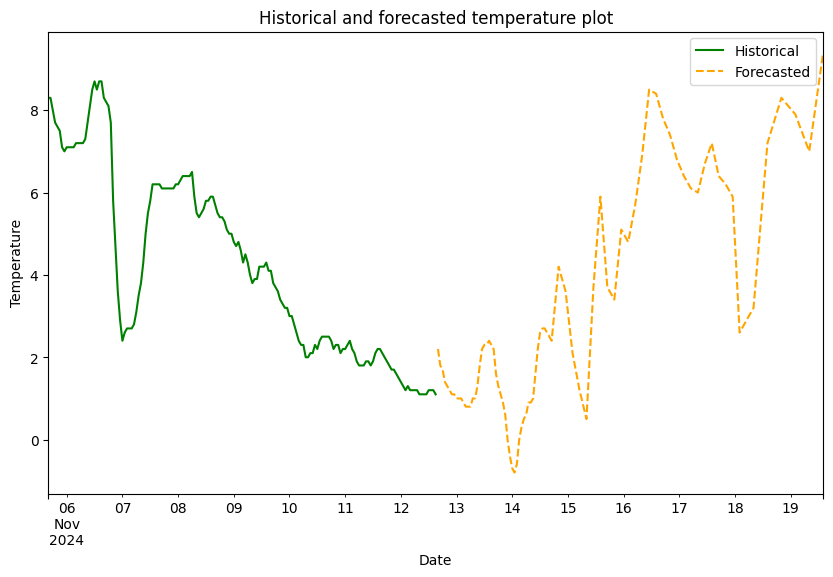

In [10]:
ts_hist = receiver.get_hist_metric("airTemperature")
ts_forec = receiver.get_forecast_metric("airTemperature")

last_days = 7
ts_hist_cut = ts_hist.tail(last_days * 24)
ts_forec = cut_forecast_start(ts_hist, ts_forec)
plot_ts(ts_hist_cut, ts_forec)

Task 4 - Resample and interpolate series

In [11]:
def resample_ts_to_five_min(ts):
    """Change series frequency to 5 min and use linear interpolation for empty values.
    Args:
        ts (pd.Series): series to change frequency
    Returns:
        data (pd.Series): series with changed frequency
    """
    data = ts.resample('5min').mean()
    data = data.interpolate()
    return data

In [12]:
print("Before resampling:")
print(ts_hist.describe())
print("After resampling:")
ts_hist_five_min = resample_ts_to_five_min(ts_hist)
print(ts_hist_five_min.describe())

Before resampling:
count    8800.000000
mean        9.453159
std         9.328385
min       -23.200000
25%         2.000000
50%         8.800000
75%        17.000000
max        32.900000
Name: airTemperature, dtype: float64
After resampling:
count    105589.000000
mean          9.453816
std           9.319207
min         -23.200000
25%           1.966667
50%           8.800000
75%          16.983333
max          32.900000
Name: airTemperature, dtype: float64
